In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

from models import BDRE, MDRE, TPE


N_DIMS = 1 # Number of dimensions
NUM_SAMPLES = 10 # Number of samples per distribution (if 3 distributions, then 3 x 33000)
BS = 64 # Batch size
NUM_EPOCHS = 500 # Number of epochs
SEED = 41
GAMMA = 1 / 3
tkwargs = {"device": "cpu", "dtype": torch.float64}

In [2]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
def forrester(x, noise=False):
#     f = (6*x - 2)**2 * np.sin(3*x - 4)
    f = np.sin(3*x) + x**2 - 0.7*x + 1
    if noise:
        f += np.random.normal(0, .2, f.shape)
    return f

In [4]:
dense_x = np.linspace(-1, 2, 1024).reshape(-1, 1)
dense_y = forrester(dense_x, noise=False)

In [5]:
X_obs = np.random.uniform(-1, 2, (10, 1))
y_obs = forrester(X_obs, noise=True)
tau = np.quantile(y_obs, q=GAMMA)

In [6]:
def split_good_bad(X, y, gamma):
    tau = np.quantile(np.unique(y), q=gamma)
    z = np.less(y, tau).flatten()

    return X, y, z, tau

In [7]:
from botorch.utils.sampling import draw_sobol_samples

def prepare_data_bdre(X_obs, y_obs, z_obs):
    X_train, y_train = torch.tensor(X_obs, **tkwargs), torch.tensor(y_obs, **tkwargs)
    z_train = torch.empty(X_obs.shape[0], dtype=torch.long).fill_(1)
    z_train[z_obs] = 0
    z_train = torch.nn.functional.one_hot(z_train).to(**tkwargs)
    
    N_p = len(z_obs[z_obs])
    N_q = len(z_obs[~z_obs])
    weight = torch.tensor([N_p / len(X_obs), N_q / len(X_obs)])
    return X_train, y_train, z_train, weight


def prepare_data_mdre(X, y, z):
    X, y, z = torch.tensor(X, **tkwargs), torch.tensor(y, **tkwargs), torch.tensor(z)
    z_idx = z.squeeze()

    x_p = X[z_idx]
    x_q = X[~z_idx]
    # squeeze the q dimension 
    x_m = draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]], **tkwargs), n=len(X), q=1).squeeze(1)
    x = torch.cat([x_p, x_q, x_m], axis=0)

    z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)
    z_q = torch.empty(x_q.shape[0], dtype=torch.long).fill_(1)
    z_m = torch.empty(x_m.shape[0], dtype=torch.long).fill_(2)
    z = torch.cat([z_p, z_q, z_m], axis=0)
    z_onehot = torch.nn.functional.one_hot(z).to(X.dtype)

    class_weight = torch.tensor([x_p.shape[0], x_q.shape[0], x_m.shape[0]]) / len(x)
    w_p = torch.empty(x_p.shape[0], 1, dtype=X.dtype).fill_(class_weight[0])
    w_q = torch.empty(x_q.shape[0], 1, dtype=X.dtype).fill_(class_weight[1])
    w_m = torch.empty(x_m.shape[0], 1, dtype=X.dtype).fill_(class_weight[2])
    w = torch.cat([w_p, w_q, w_m], axis=0)
    
    y = forrester(x)
    return x, y, z_onehot, w, class_weight

In [8]:
def plot_step_through_tpe(X_obs, y_obs, z_obs, new_x, new_y, tau, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    # tpe
    x_p = X_obs[z_obs]
    y_p = y_obs[z_obs]
    x_q = X_obs[~z_obs]
    y_q = y_obs[~z_obs]
    
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('TPE')

    good_density = np.exp(tpe.kde_good.score_samples(dense_x))
    bad_density = np.exp(tpe.kde_bad.score_samples(dense_x))
    ax_func.fill_between(
        dense_x.flatten(),
        good_density,
        0,
        facecolor="#d627283f",
        edgecolor="#d62728",
        label=r"$\ell(x)$",
    )
    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    
    ax_func.fill_between(
        dense_x.flatten(),
        bad_density,
        0,
        facecolor="#1f77b43f",
        edgecolor="#1f77b4",
        label=r"$g(x)$",
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )
#     ax_func.legend()

    ax_acf.fill_between(
        dense_x.flatten(),
        acf,
        0,
        facecolor="#2ca02c3f",
        edgecolor="#2ca02c",
        label=r"$\ell(x)$",
    )
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

    
def plot_step_through_bdre(X_obs, y_obs, z_obs, new_x, new_y, tau, dr, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs[z_obs[:, 0].bool()]
    y_p = y_obs[z_obs[:, 0].bool()]
    x_q = X_obs[z_obs[:, 1].bool()]
    y_q = y_obs[z_obs[:, 1].bool()]

    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.scatter(dense_x, acf[:, 0], s=1, color='tab:red',)
    ax_func.scatter(dense_x, acf[:, 1], s=1, color='tab:blue',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('BDRE')

    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )

    ax_acf.fill_between(
        dense_x.flatten(),
        dr,
        0,
        facecolor="#2ca02c3f",
        edgecolor="#2ca02c",
        label=r"$\ell(x)$",
    )
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')


def plot_step_through_mdre(X_obs, y_obs, z_obs, new_x, new_y, tau, dr, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs[z_obs[:, 0].bool()]
    y_p = y_obs[z_obs[:, 0].bool()]
    x_q = X_obs[z_obs[:, 1].bool()]
    y_q = y_obs[z_obs[:, 1].bool()]
    x_m = X_obs[z_obs[:, 2].bool()]
    
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.scatter(dense_x, acf[:, 0], s=1, color='tab:red',)
    ax_func.scatter(dense_x, acf[:, 1], s=1, color='tab:blue',)
    ax_func.scatter(dense_x, acf[:, 2], s=1, color='tab:green',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('MDRE')

    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )
    ax_func.plot(
        x_m,
        np.zeros(len(x_m)),
        '|',
        markersize=12,
        color="tab:green"
    )

    ax_acf.fill_between(
        dense_x.flatten(),
        dr,
        0,
        facecolor="#2ca02c3f",
        edgecolor="#2ca02c",
        label=r"$\ell(x)$",
    )
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

def plot_step_through_lfbo(X_obs, y_obs, new_x, new_y, acf_mean, acf_samples, ax_func, ax_acf):
    X_obs_rff, y_obs_rff, z_obs_rff, tau = split_good_bad(X_obs, y_obs, gamma=GAMMA)
    acf_std = torch.std(acf_samples, axis=0).numpy()

    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs_rff[z_obs_rff]
    y_p = y_obs_rff[z_obs_rff]
    x_q = X_obs_rff[~z_obs_rff]
    y_q = y_obs_rff[~z_obs_rff]
    
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    # ax_func.scatter(dense_x, acf_mean + 2 * acf_std, s=1, color='tab:red',)
    # ax_func.scatter(dense_x, 1-acf_samples, s=1, color='tab:blue',)
    ax_func.set_xlim(-1., 2.)
#     ax_func.set_ylim(0, None)
    ax_func.set_title('LFBO_RFF')

    ax_func.plot(
        x_p,
        np.zeros(len(x_p)),
        '|',
        markersize=12,
        color="tab:red"
    )
    ax_func.plot(
        x_q,
        np.zeros(len(x_q)),
        '|',
        markersize=12,
        color="tab:blue"
    )
    ax_acf.plot(
        dense_x,
        acf_mean.reshape(dense_x.shape),
        c='k',
        label="mean",
    )
#     for n, posterior_sample in enumerate(acf_samples):
#         ax_acf.plot(
#             dense_x,
#             posterior_sample.reshape(dense_x.shape),
#             alpha=.6,
#             label='posterior samples' if n<1 else None
#         )
#         if n > 1:
#             break

    ax_acf.fill_between(
        dense_x.flatten(),
        (acf_mean+2*acf_std).ravel(),
        (acf_mean-2*acf_std).ravel(),
        color="tab:gray",
        alpha=0.3,
        label="confidence interval",
    )
    
    ax_acf.set_xlim(-1, 2)
    ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

In [9]:
import math
from typing import Optional
from collections import OrderedDict

import torch
from torch import Tensor
from botorch.posteriors.gpytorch import GPyTorchPosterior
from gpytorch.distributions import MultivariateNormal
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.utils.transforms import t_batch_mode_transform
from botorch.sampling.normal import SobolQMCNormalSampler

class MCDropout_MLP(torch.nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        num_hidden_units,
        num_hidden_layers,
        dropout_rate=0.2,
        device="cpu:0",
        dtype=torch.double,
    ) -> None:
        super().__init__()
        self.tkwargs = {"dtype": dtype, "device": device}

        layers = []
        layers.append((f"input_layer", torch.nn.Linear(input_dim, num_hidden_units)))
        layers.append((f"input_activation", torch.nn.ELU()))
        layers.append((f"dropout", torch.nn.Dropout(dropout_rate)))
        for i in range(num_hidden_layers):
            layers.append((f"hidden_layer_{i}", torch.nn.Linear(num_hidden_units, num_hidden_units)))
            layers.append((f"activation_{i}", torch.nn.ELU()))
            layers.append((f"dropout_{i}", torch.nn.Dropout(dropout_rate)))
        layers.append((f"hidden_layer", torch.nn.Linear(num_hidden_units, 1)))
        layers.append((f"activation", torch.nn.ELU()))
        layers.append((f"dropout", torch.nn.Dropout(dropout_rate)))
        self.layers = torch.nn.Sequential(OrderedDict(layers))

    def check_input_dims(self, X):
        # check if X has batch dimension
        if len(X.shape) == 1:
            X = X[..., None, None]
        elif len(X.shape) == 2:
            X = X[:, None, :]
        # X should have: num_obs x n_dim x 1
        return X

    def forward(self, X, y=None, w=None):
        # Residual Feedfoward Network
        # first pass through input layer
        logits = self.layers[0](X)
        # hidden residual block
        for i in range(1, len(self.layers) - 2):
            if isinstance(self.layers[i], torch.nn.Linear):
                identity = logits
                logits = self.layers[i](logits)
                logits += identity
            else:
                logits = self.layers[i](logits)
        logits = self.layers[-2](logits)  # feature layer
        logits = self.layers[-1](logits)  # activation

        return logits
    
    @staticmethod
    def split_good_bad(X, y, gamma, acq_type='ei'):
        tau = torch.quantile(torch.unique(y), q=gamma)
        z = torch.less(y, tau)

        if len(X) > 1 and acq_type == 'ei':
            z_idx = z.squeeze()

            x1, z1 = X[z_idx], z[z_idx].to(X.dtype)
            x0, z0 = X, torch.zeros_like(z).to(X.dtype)

            w1 = (tau - y)[z_idx]
            # sometimes w1 is empty
            w1 = w1 / torch.mean(w1) if len(w1) else w1
            w0 = 1 - z0

            x = torch.concat([x1, x0], axis=0)
            z = torch.concat([z1, z0], axis=0)
            s1 = x1.shape[0]
            s0 = x0.shape[0]

            w = torch.concat([w1 * (s1 + s0) / s1, w0 * (s1 + s0) / s0], axis=0)
            w = w / torch.mean(w)

        elif len(X) == 1 or acq_type == 'pi':
            x = X
            w = torch.ones_like(z).to(X.dtype)

        return x, y, z, w
    
    def fit(self, X, y, gamma, batch_size=256, S=50):
        X = self.check_input_dims(X)

        new_X, _, z, w = self.split_good_bad(X.detach(), y.detach(), gamma=gamma)

        # add batch dim
        train_tensor = [new_X, z.unsqueeze(1), w.unsqueeze(1)]
        train_dataset = torch.utils.data.TensorDataset(*train_tensor)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))

        N = len(X)  # N-th iteration
        M = math.ceil(N / batch_size)  # Steps per epochs
        E = math.floor(S / M)

        optimizer = torch.optim.Adam(self.parameters())
        # update the models
        self.train()
        for epochs in range(E):
            for _, (inputs, targets, weights) in enumerate(train_dataloader):
                optimizer.zero_grad(set_to_none=True)

                outputs = self(inputs, targets, weights)
                batch_loss = torch.nn.functional.binary_cross_entropy_with_logits(
                    outputs, targets, weight=weights
                )
                batch_loss.backward()
                optimizer.step()
        self.eval()

    def posterior(self, X, num_samples=100):
        self.train()
        # X: b x q x d
        if len(X.size()) == 2:
            X = X.unsqueeze(0)

        with torch.no_grad():
            samples = torch.empty(0, X.shape[1], 1)
            for _ in range(num_samples):
                logits = self(X)
                probs = torch.sigmoid(logits)
                samples = torch.cat([samples, probs], axis=0)
        mean = torch.mean(samples, axis=0)
        std = torch.std(samples, axis=0)
        
        return mean, std, samples

100%|██████████| 500/500 [00:00<00:00, 914.65it/s]


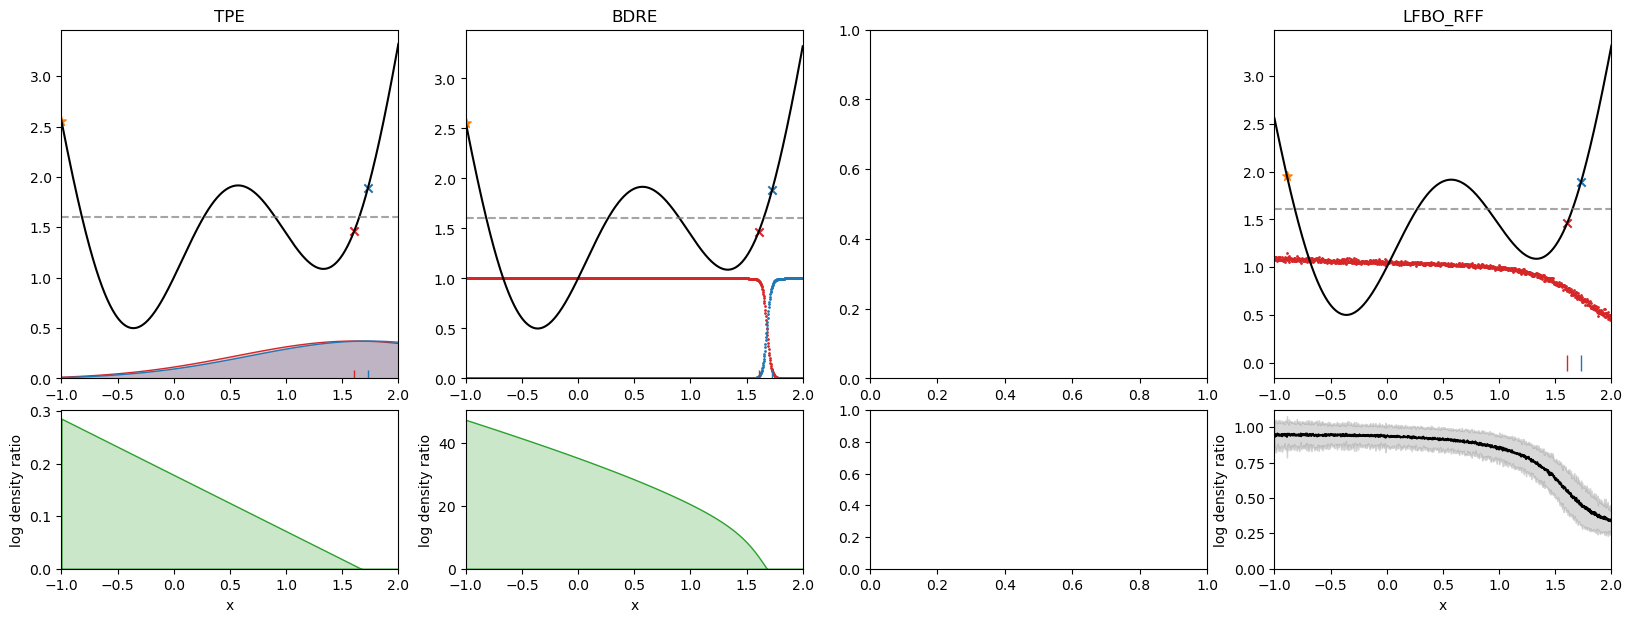

100%|██████████| 500/500 [00:00<00:00, 970.58it/s]


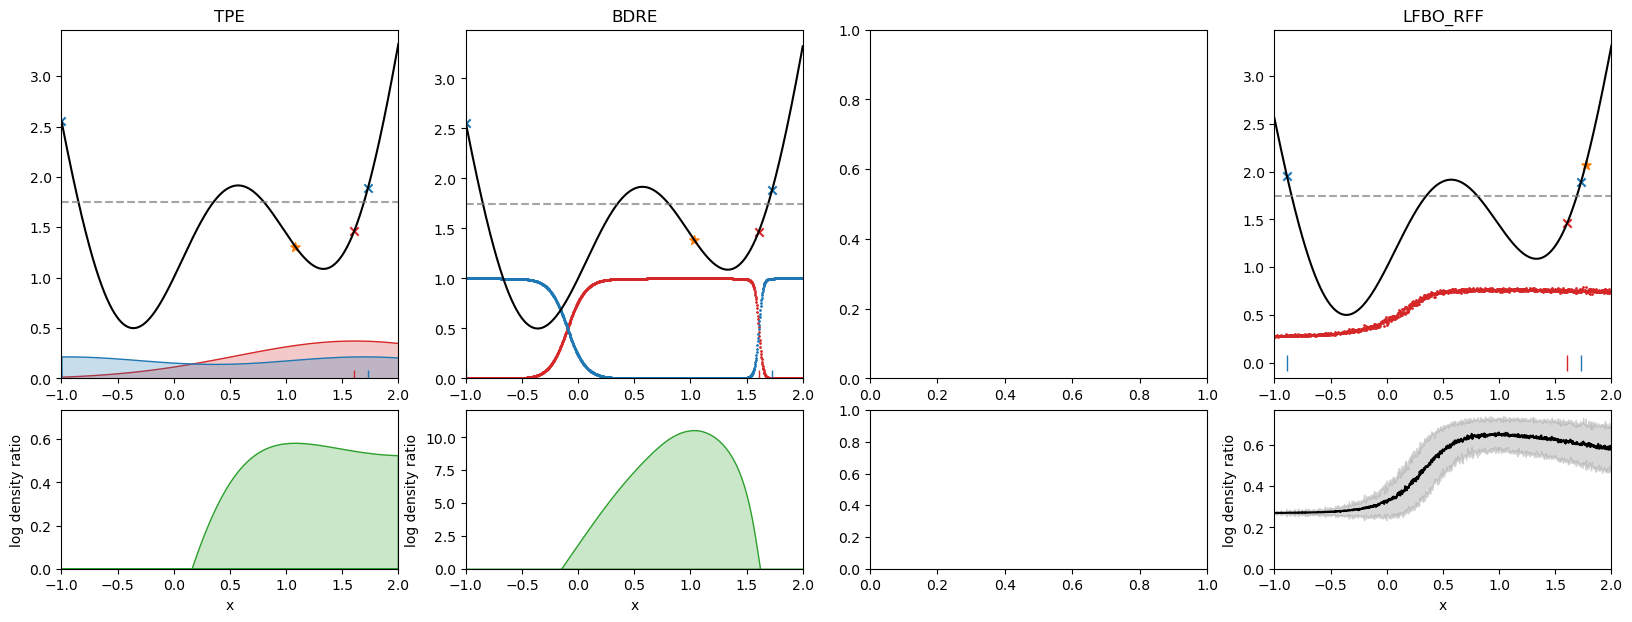

100%|██████████| 500/500 [00:00<00:00, 954.99it/s]


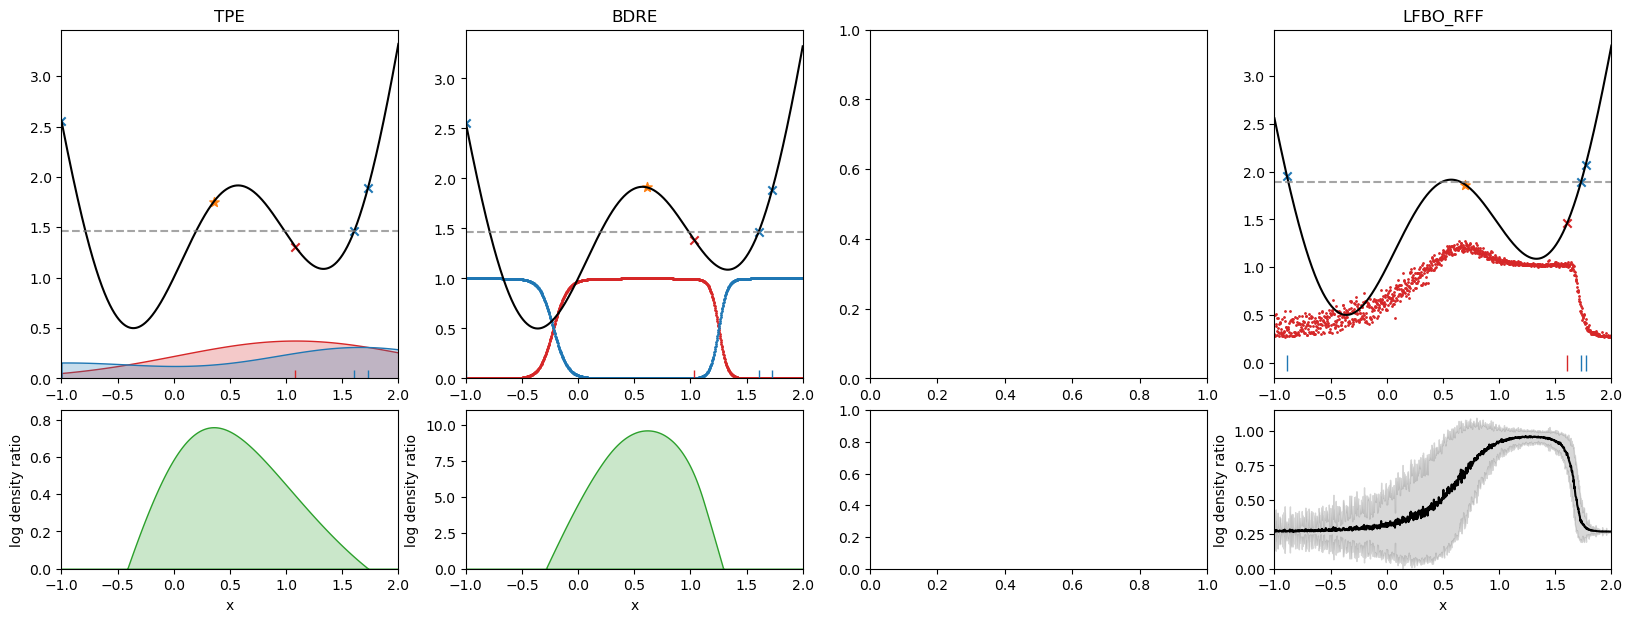

100%|██████████| 500/500 [00:00<00:00, 918.55it/s]


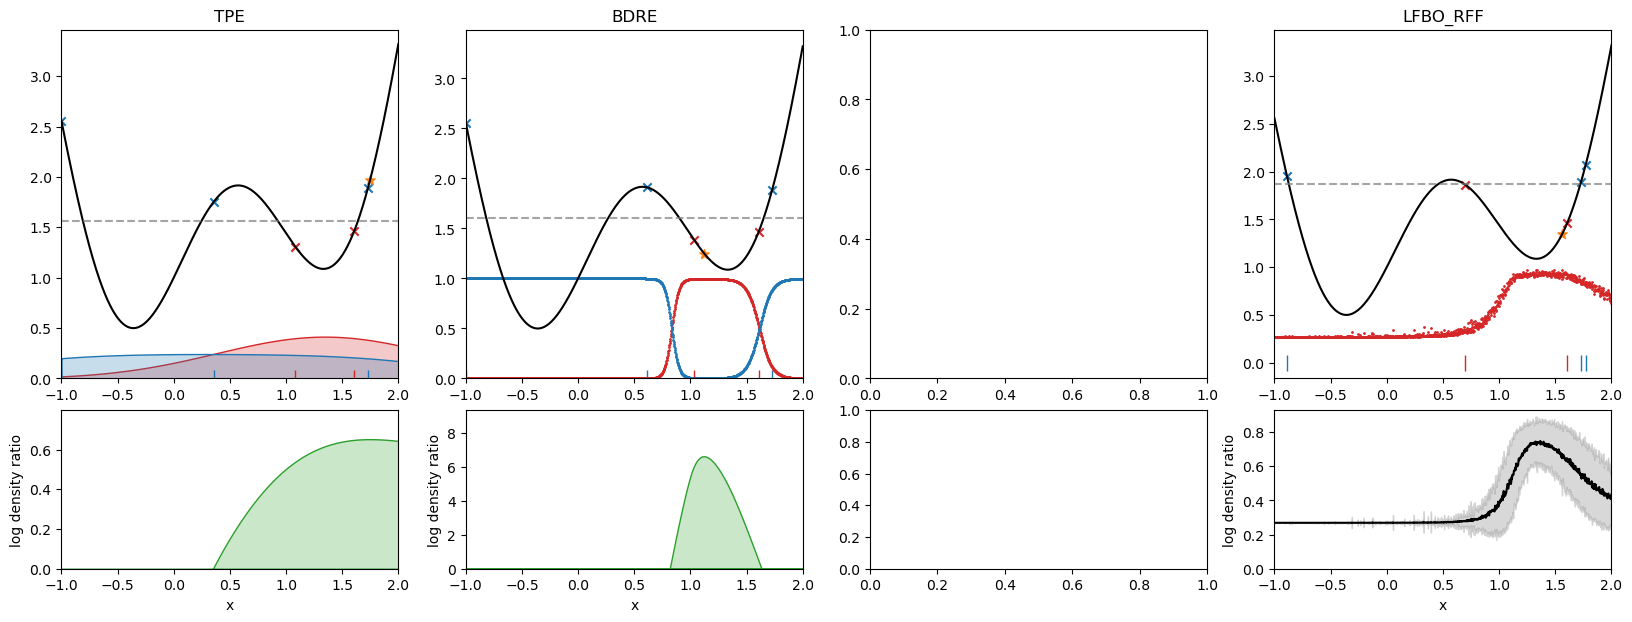

100%|██████████| 500/500 [00:00<00:00, 936.38it/s]


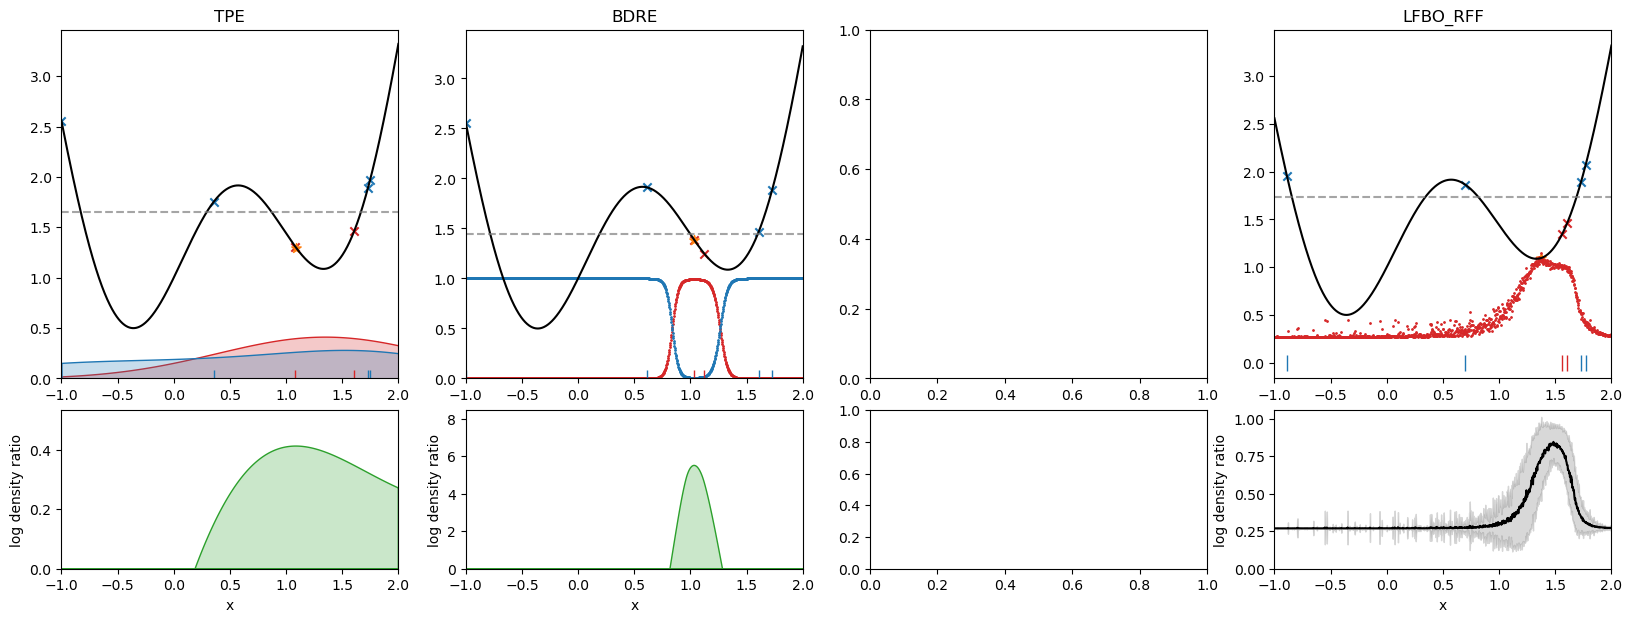

100%|██████████| 500/500 [00:00<00:00, 929.32it/s]


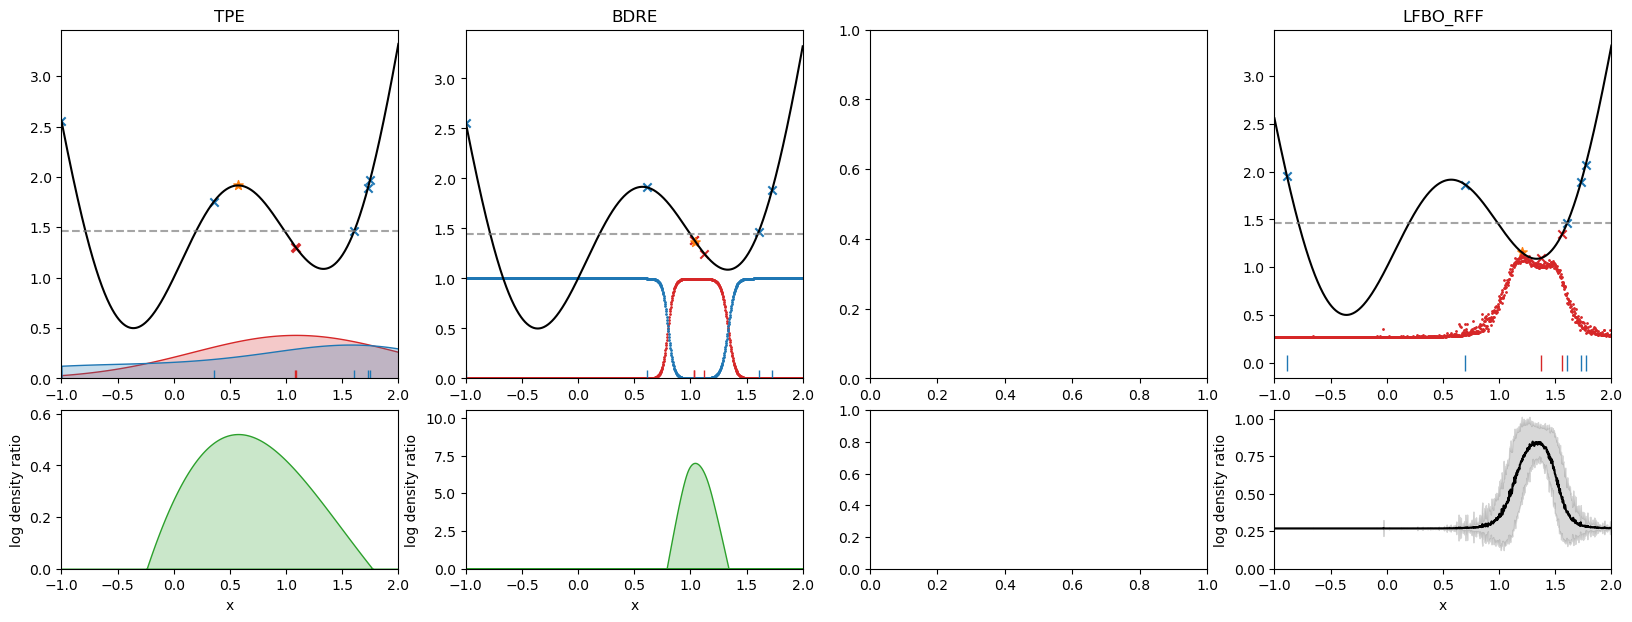

100%|██████████| 500/500 [00:00<00:00, 932.47it/s]


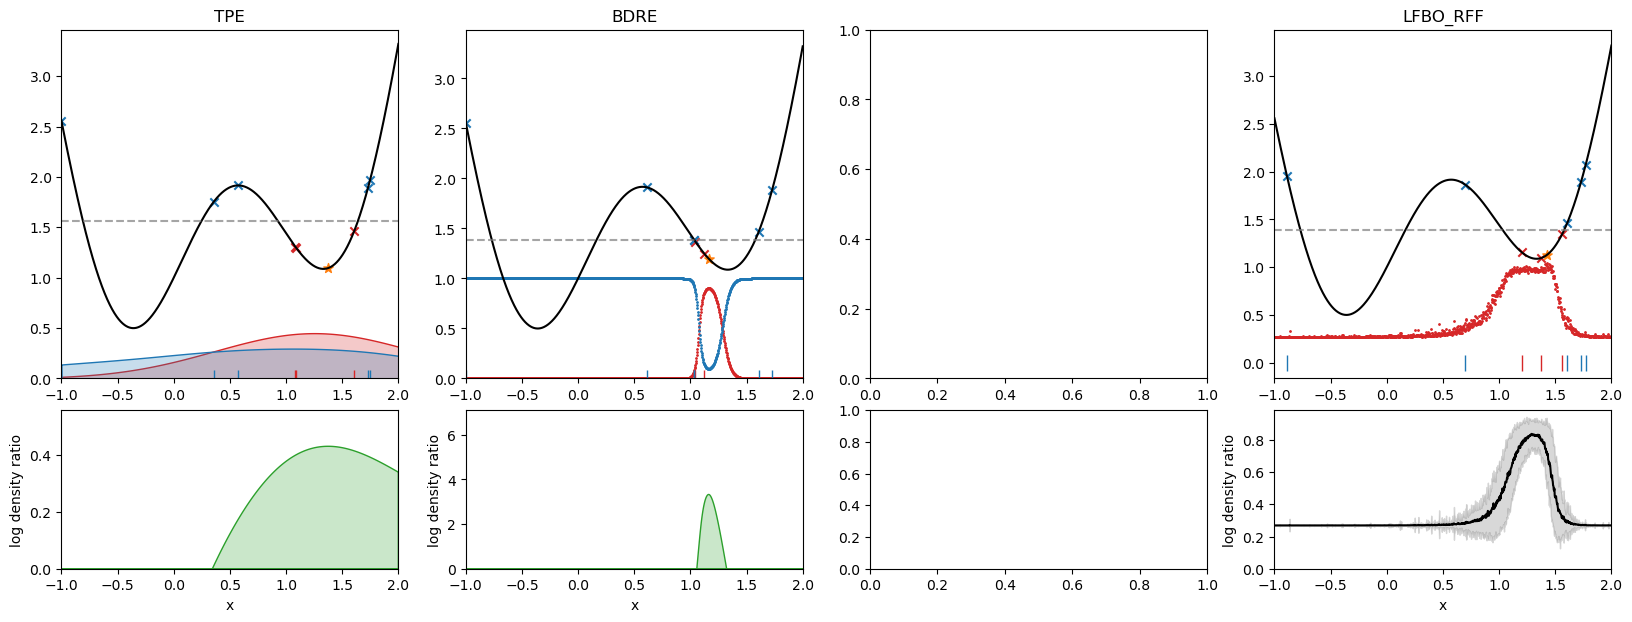

100%|██████████| 500/500 [00:00<00:00, 907.18it/s]


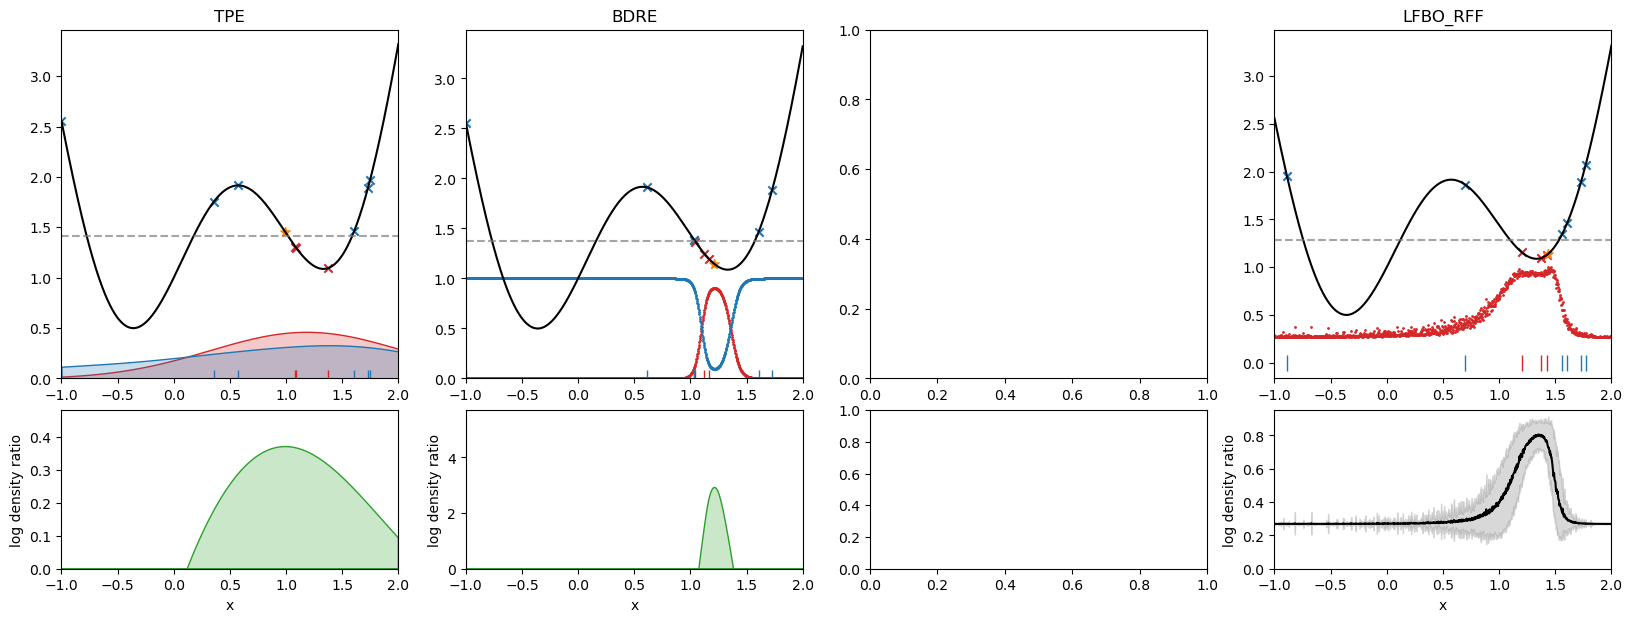

100%|██████████| 500/500 [00:00<00:00, 924.64it/s]


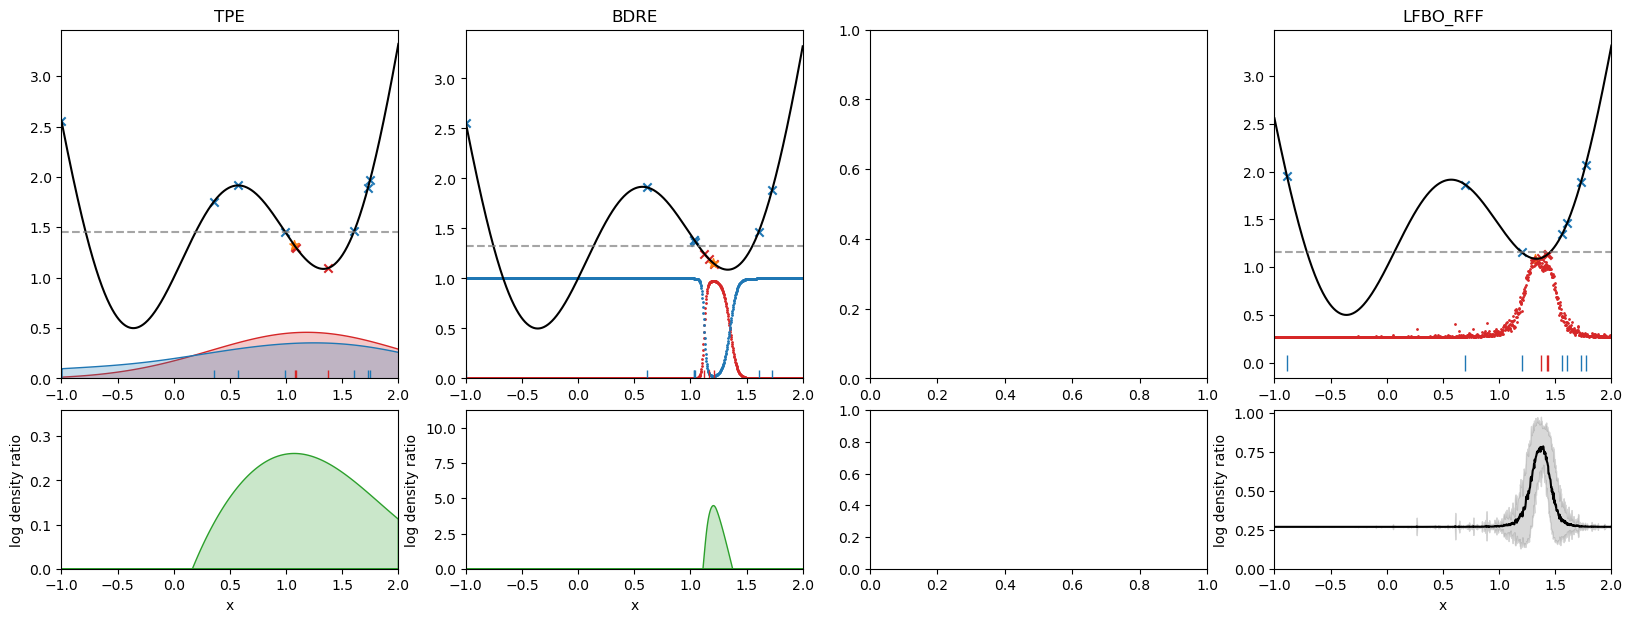

100%|██████████| 500/500 [00:00<00:00, 902.95it/s]


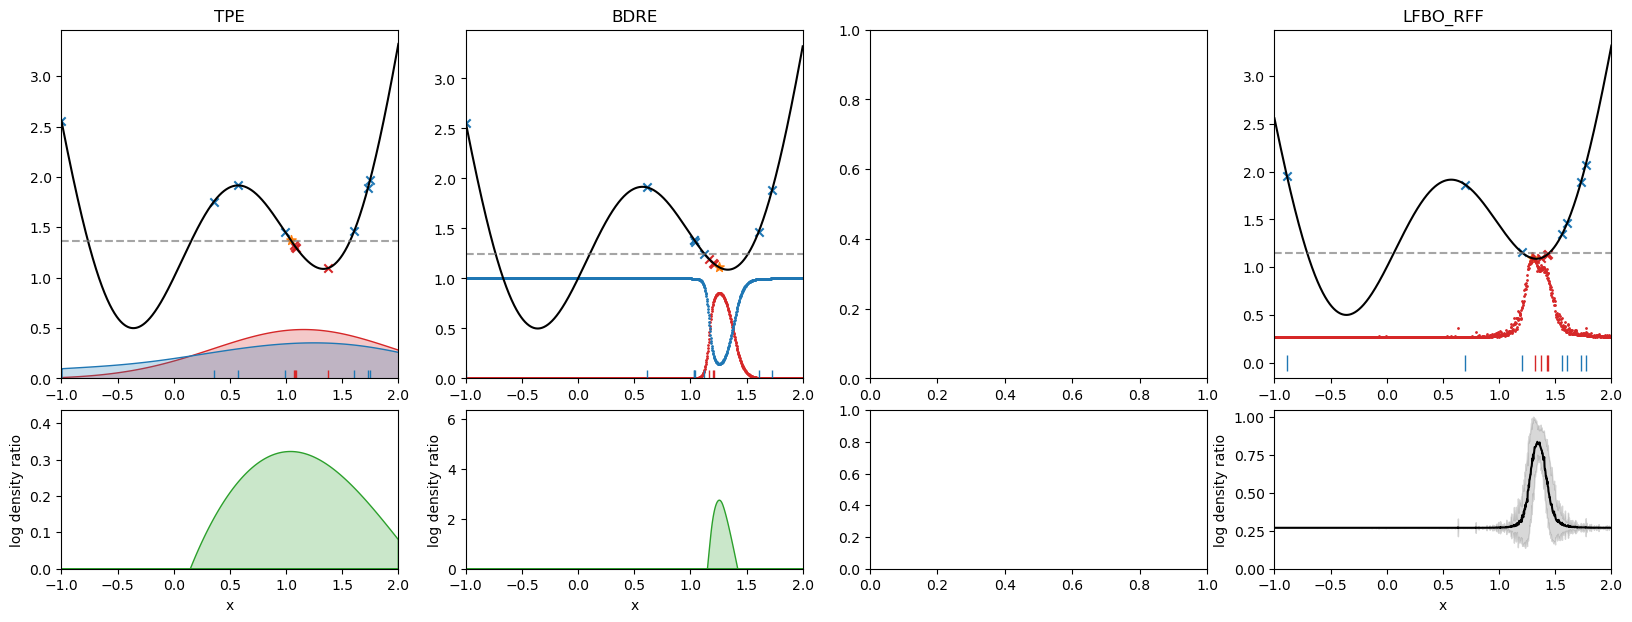

100%|██████████| 500/500 [00:00<00:00, 905.16it/s]


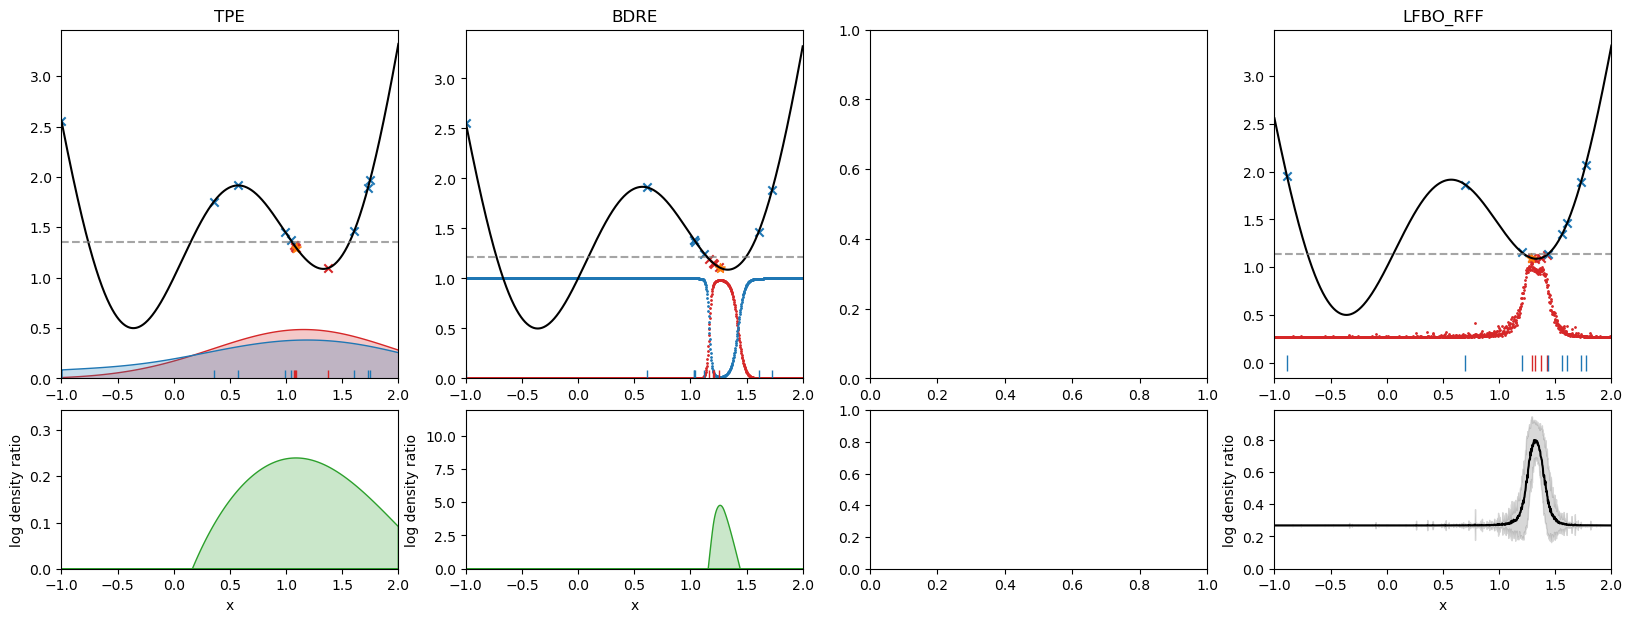

100%|██████████| 500/500 [00:00<00:00, 903.77it/s]


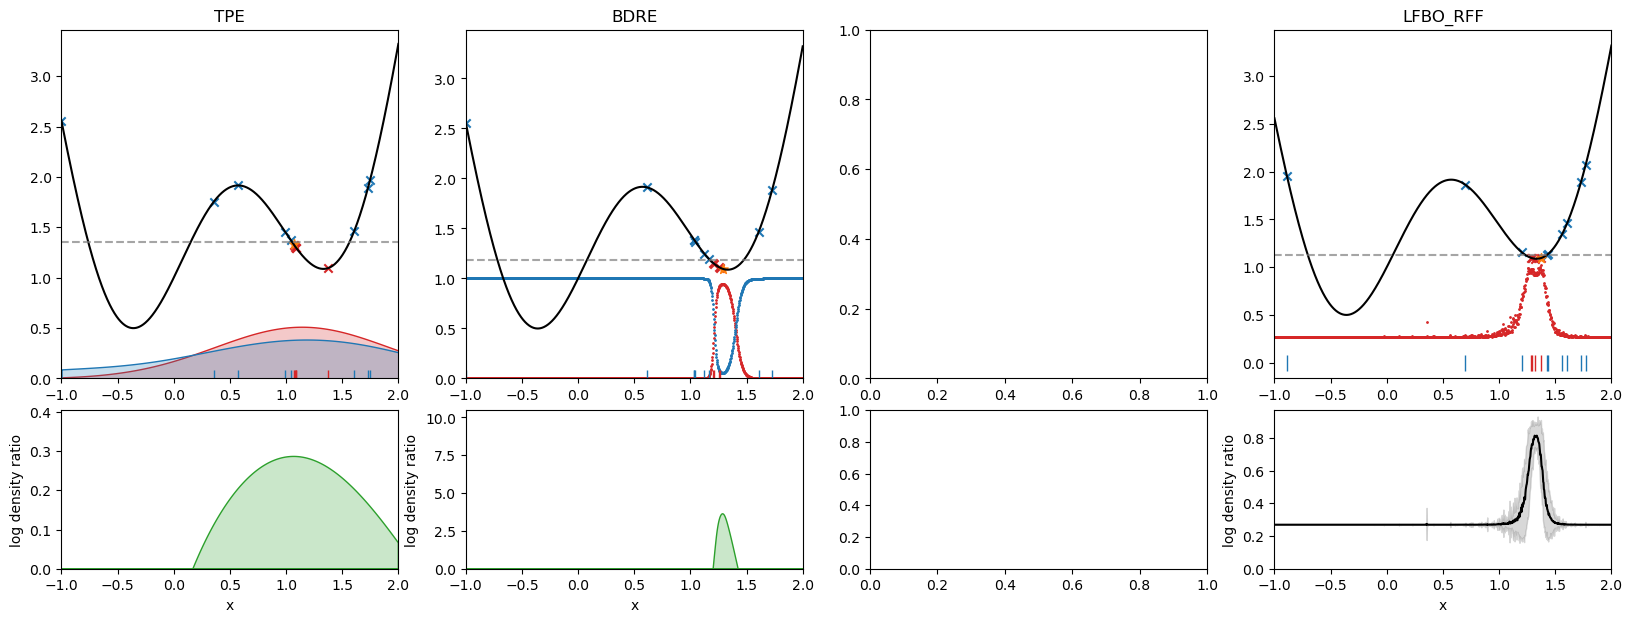

100%|██████████| 500/500 [00:00<00:00, 886.47it/s]


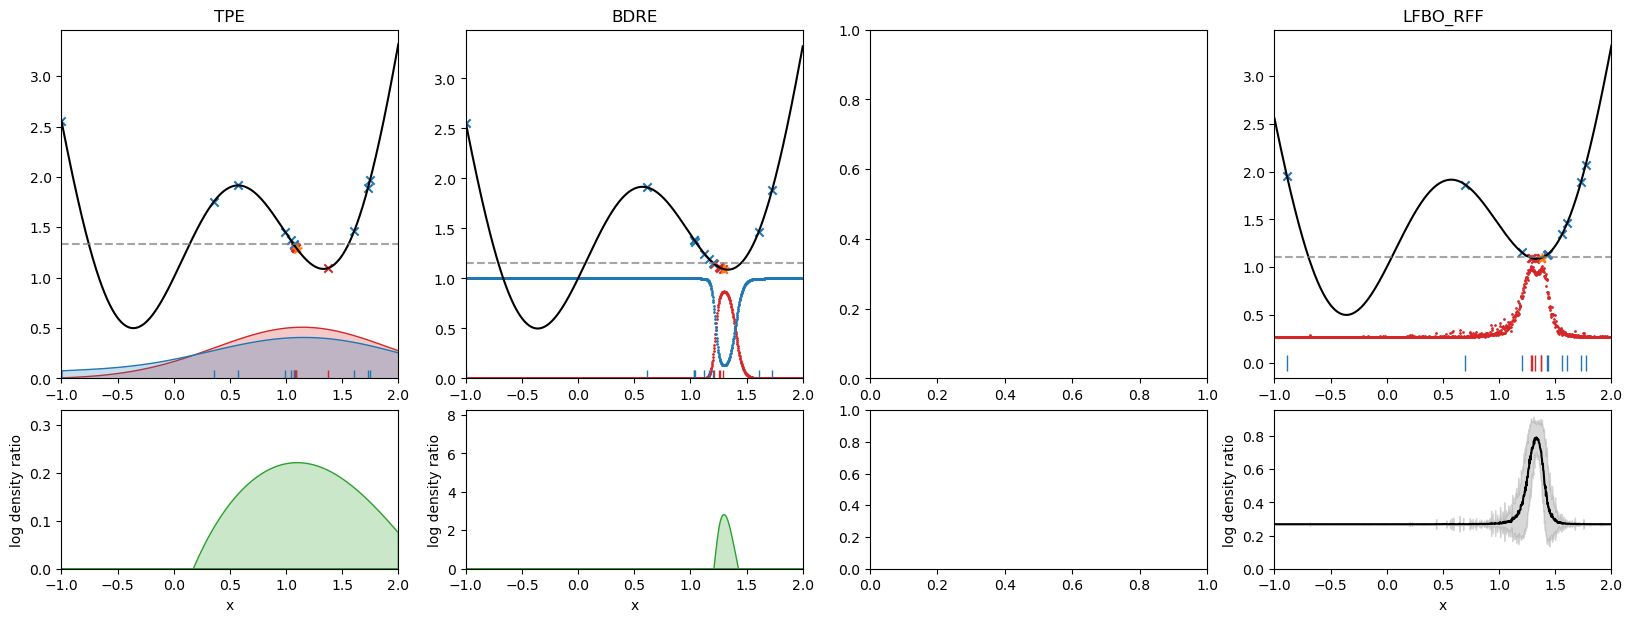

100%|██████████| 500/500 [00:00<00:00, 894.16it/s]


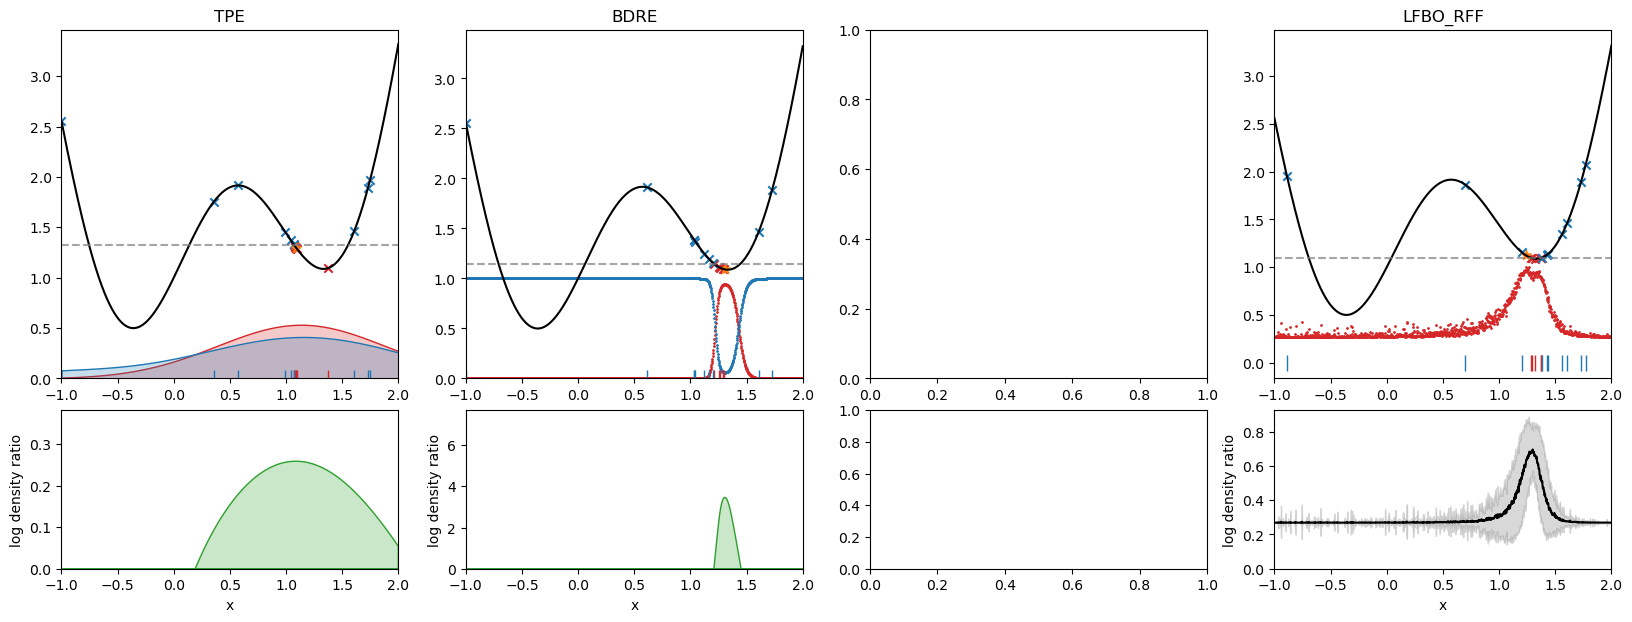

100%|██████████| 500/500 [00:00<00:00, 890.87it/s]


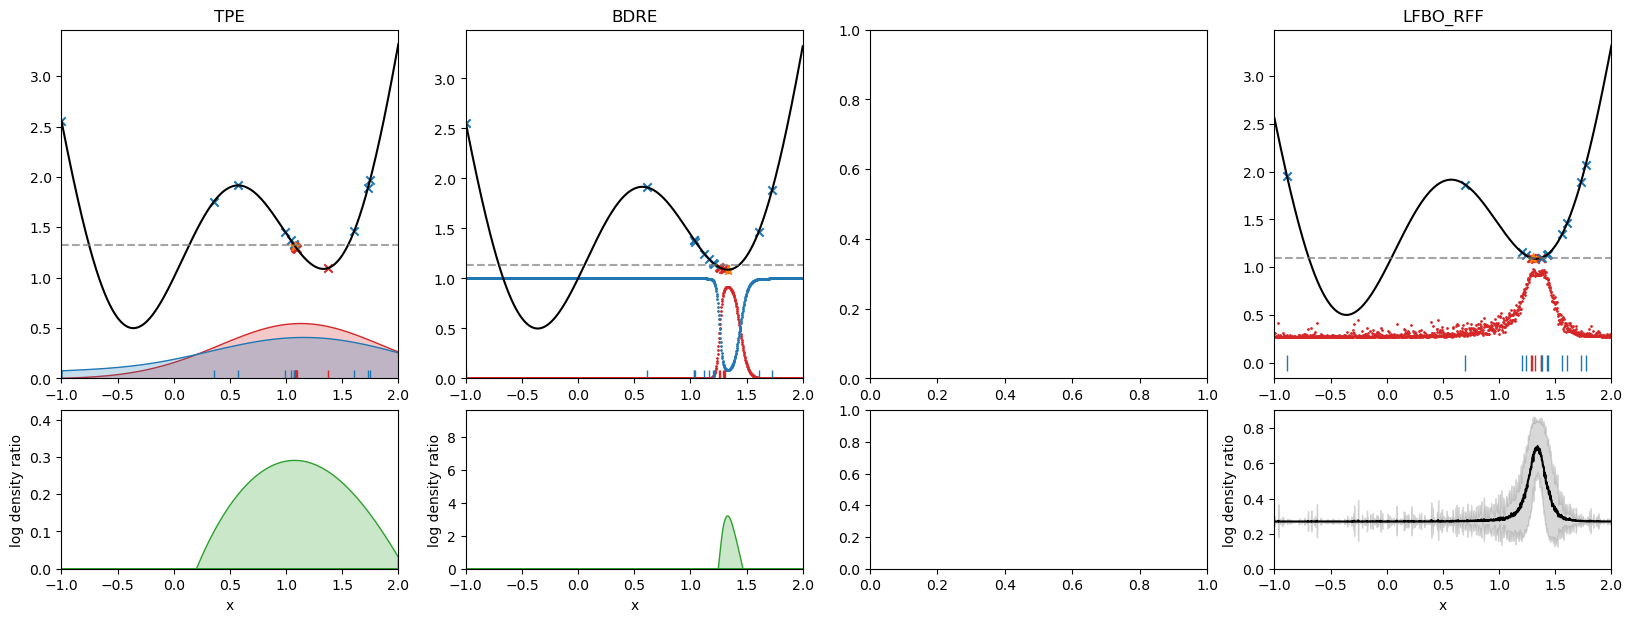

100%|██████████| 500/500 [00:00<00:00, 860.17it/s]


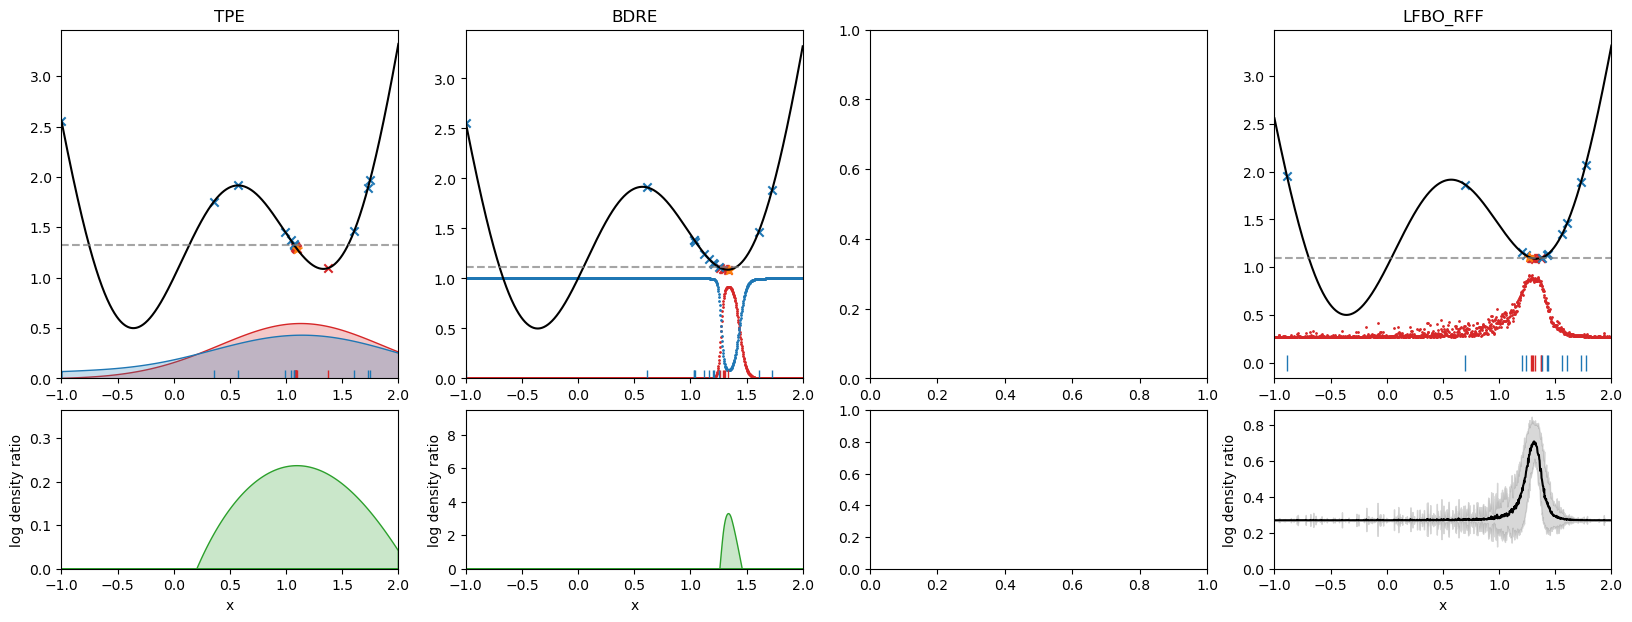

In [10]:
X_obs = np.random.uniform(1, 2, (2, 1))
y_obs = forrester(X_obs, noise=False)

X_obs_tpe, y_obs_tpe = X_obs, y_obs
X_obs_bdre, y_obs_bdre = X_obs, y_obs
X_obs_mdre, y_obs_mdre = X_obs, y_obs
X_obs_rff, y_obs_rff = X_obs, y_obs

num_evaluations = 16

for n in range(num_evaluations):
    
    fig = plt.figure(figsize=(20, 7))
    ax_func_tpe = plt.subplot2grid((3, 4), (0, 0), rowspan=2)
    ax_acf_tpe = plt.subplot2grid((3, 4), (2, 0), rowspan=1)
    ax_func_bdre = plt.subplot2grid((3, 4), (0, 1), rowspan=2)
    ax_acf_bdre = plt.subplot2grid((3, 4), (2, 1), rowspan=1)
    ax_func_mdre = plt.subplot2grid((3, 4), (0, 2), rowspan=2)
    ax_acf_mdre = plt.subplot2grid((3, 4), (2, 2), rowspan=1)
    ax_func_lfbo = plt.subplot2grid((3, 4), (0, 3), rowspan=2)
    ax_acf_lfbo = plt.subplot2grid((3, 4), (2, 3), rowspan=1)

    # tpe
    tpe = TPE(kernel='gaussian')
    X_obs_tpe, y_obs_tpe, z_obs_tpe, tau = split_good_bad(X_obs_tpe, y_obs_tpe, gamma=GAMMA)
    tpe.fit(X_obs_tpe, y_obs_tpe, z_obs_tpe)
    acf_tpe = tpe.predict(dense_x)
    new_x = dense_x[np.argmax(acf_tpe)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_tpe(X_obs_tpe, y_obs_tpe, z_obs_tpe, new_x, new_y, tau, acf_tpe, ax_func_tpe, ax_acf_tpe)
    X_obs_tpe = np.concatenate([X_obs_tpe, new_x.reshape(-1, 1)])
    y_obs_tpe = np.concatenate([y_obs_tpe, new_y.reshape(-1, 1)])

    # bdre
    X_obs_bdre, y_obs_bdre, z_obs_bdre, tau = split_good_bad(X_obs_bdre, y_obs_bdre, gamma=GAMMA)
    X_train_bdre, y_train_bdre, z_train_bdre, weight = prepare_data_bdre(X_obs_bdre, y_obs_bdre, z_obs_bdre)
    bdre = BDRE(input_dim=1, output_dim=2, **tkwargs)
    bdre.fit(X_train_bdre, z_train_bdre, weight=weight, S=500)
    bdre_preds = bdre.predict(torch.from_numpy(dense_x))
    dr_bdre = (bdre_preds[:, 0] - bdre_preds[:, 1]).numpy()
    acf_bdre = torch.nn.functional.softmax(bdre_preds + torch.log(weight), dim=-1).numpy()
    new_x = dense_x[np.argmax(dr_bdre)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_bdre(X_train_bdre, y_train_bdre, z_train_bdre, new_x, new_y, tau, dr_bdre, acf_bdre, ax_func_bdre, ax_acf_bdre)
    X_obs_bdre = np.concatenate([X_obs_bdre, new_x.reshape(-1, 1)])
    y_obs_bdre = np.concatenate([y_obs_bdre, new_y.reshape(-1, 1)])
    

    # lfbo_rff
    lfbo = MCDropout_MLP(input_dim=1, output_dim=1, dropout_rate=0.1, num_hidden_units=32, num_hidden_layers=3, **tkwargs)
    lfbo.to(**tkwargs)
    lfbo.fit(torch.from_numpy(X_obs_rff), torch.from_numpy(y_obs_rff), gamma=GAMMA, S=1000)
    acf_mean, std, acf_samples = lfbo.posterior(torch.from_numpy(dense_x))
    acq_values = acf_mean + 3*std
    new_x = dense_x[torch.argmax(acf_mean + 3 * std)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_lfbo(X_obs_rff, y_obs_rff, new_x, new_y, acf_mean, acf_samples, ax_func_lfbo, ax_acf_lfbo)
    ax_func_lfbo.scatter(dense_x, acq_values, s=1, color='tab:red',)
    X_obs_rff = np.concatenate([X_obs_rff, new_x.reshape(-1, 1)])
    y_obs_rff = np.concatenate([y_obs_rff, new_y.reshape(-1, 1)])

    plt.show()